In [54]:
import pandas as pd
import requests
import glob
from io import BytesIO
import numpy as np
import os
import shutil

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
#path = Path('data/food-101/images')
path = Path('../data/subset')


In [4]:
data = ImageDataBunch.from_folder(path, valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4, bs=64).normalize(imagenet_stats)

In [5]:
data.classes


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 10,
 8035,
 1965)

In [7]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)


In [8]:
#learn = create_cnn(data, models.resnet34, metrics=error_rate, model_dir="../../prod")
#learn.model = torch.nn.DataParallel(learn.model)


In [9]:
learn.fit_one_cycle(4)


Total time: 03:03
epoch  train_loss  valid_loss  error_rate
1      0.897566    0.645430    0.216285    (00:47)
2      0.595806    0.492758    0.157252    (00:44)
3      0.434488    0.452815    0.150127    (00:45)
4      0.336350    0.433548    0.141985    (00:45)



In [10]:
model_name="resnet50"

In [11]:
learn.save(f'{model_name}-stage-1')

In [12]:
learn.load(f'{model_name}-stage-1')

In [13]:
learn.unfreeze()


In [14]:
learn.lr_find(start_lr=1e-09, end_lr=1e-3)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


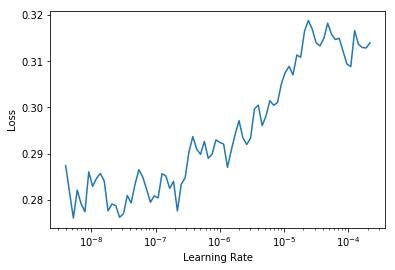

In [15]:
learn.recorder.plot(skip_end=10)


In [16]:
learn.fit_one_cycle(5, max_lr=slice(1e-7,1e-4))


Total time: 04:06
epoch  train_loss  valid_loss  error_rate
1      0.301539    0.429736    0.137405    (00:49)
2      0.304044    0.420826    0.136387    (00:49)
3      0.278203    0.413375    0.136387    (00:49)
4      0.262110    0.413985    0.133333    (00:48)
5      0.265581    0.412471    0.133842    (00:49)



In [17]:
learn.save(f'{model_name}-stage-2')

# Interpretation

In [18]:
learn.load(f'{model_name}-stage-2')


In [19]:
interp = ClassificationInterpretation.from_learner(learn)


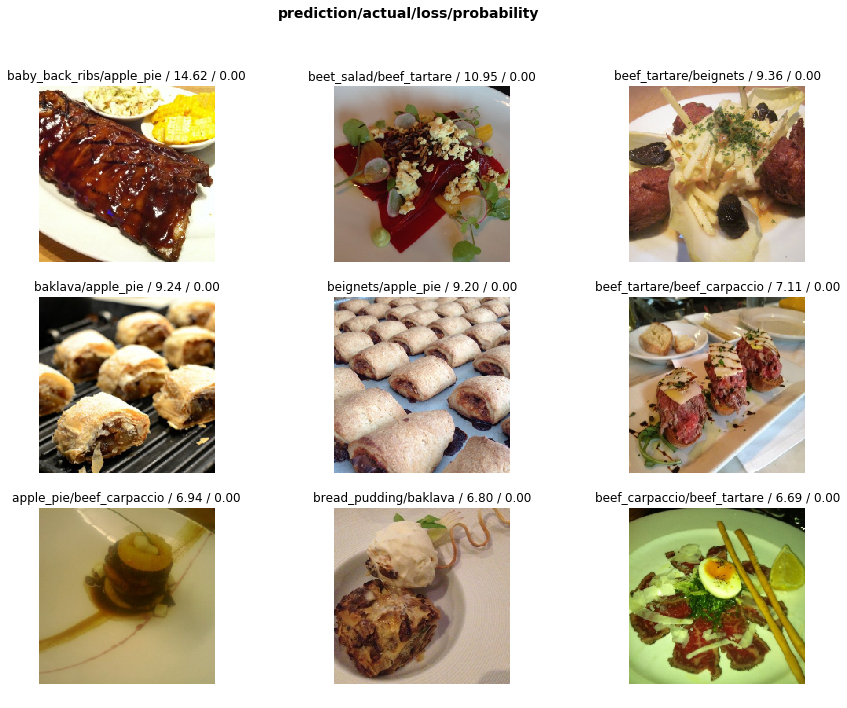

In [20]:
interp.plot_top_losses(9, figsize=(15,11))


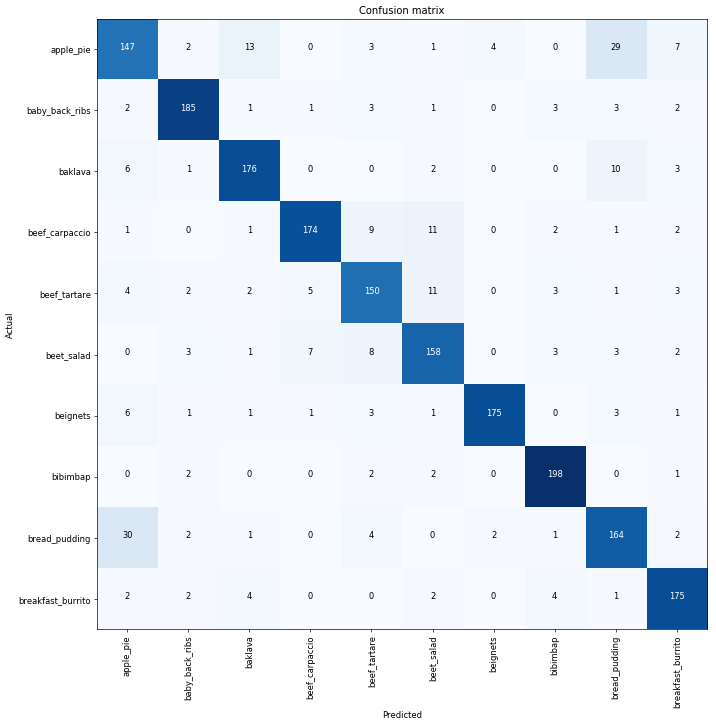

In [21]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [22]:
interp.most_confused(min_val=2)


[('bread_pudding', 'apple_pie', 30),
 ('apple_pie', 'bread_pudding', 29),
 ('apple_pie', 'baklava', 13),
 ('beef_carpaccio', 'beet_salad', 11),
 ('beef_tartare', 'beet_salad', 11),
 ('baklava', 'bread_pudding', 10),
 ('beef_carpaccio', 'beef_tartare', 9),
 ('beet_salad', 'beef_tartare', 8),
 ('apple_pie', 'breakfast_burrito', 7),
 ('beet_salad', 'beef_carpaccio', 7),
 ('baklava', 'apple_pie', 6),
 ('beignets', 'apple_pie', 6),
 ('beef_tartare', 'beef_carpaccio', 5),
 ('apple_pie', 'beignets', 4),
 ('beef_tartare', 'apple_pie', 4),
 ('bread_pudding', 'beef_tartare', 4),
 ('breakfast_burrito', 'baklava', 4),
 ('breakfast_burrito', 'bibimbap', 4),
 ('apple_pie', 'beef_tartare', 3),
 ('baby_back_ribs', 'beef_tartare', 3),
 ('baby_back_ribs', 'bibimbap', 3),
 ('baby_back_ribs', 'bread_pudding', 3),
 ('baklava', 'breakfast_burrito', 3),
 ('beef_tartare', 'bibimbap', 3),
 ('beef_tartare', 'breakfast_burrito', 3),
 ('beet_salad', 'baby_back_ribs', 3),
 ('beet_salad', 'bibimbap', 3),
 ('beet_sa

In [34]:
final_model_name = f'{model_name}-final'

In [35]:
learn.save(final_model_name)

# Testing on Different Data

In [36]:
learn.load(final_model_name)

In [37]:
learn.data.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [39]:
data2 = ImageDataBunch.single_from_classes(path, data.classes
                                           , tfms=get_transforms()
                                           , size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet50)
learn.load(final_model_name)

In [40]:
data2.classes, data2.c


(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 10)

In [43]:
bibimbap_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/44/Dolsot-bibimbap.jpg/1200px-Dolsot-bibimbap.jpg"

In [41]:
baby_back_url ="https://upload.wikimedia.org/wikipedia/commons/e/ee/Baby_back_ribs_with_fries.jpg"

In [ ]:
#!wget {url} -O sample.jpg

In [44]:
url = bibimbap_url

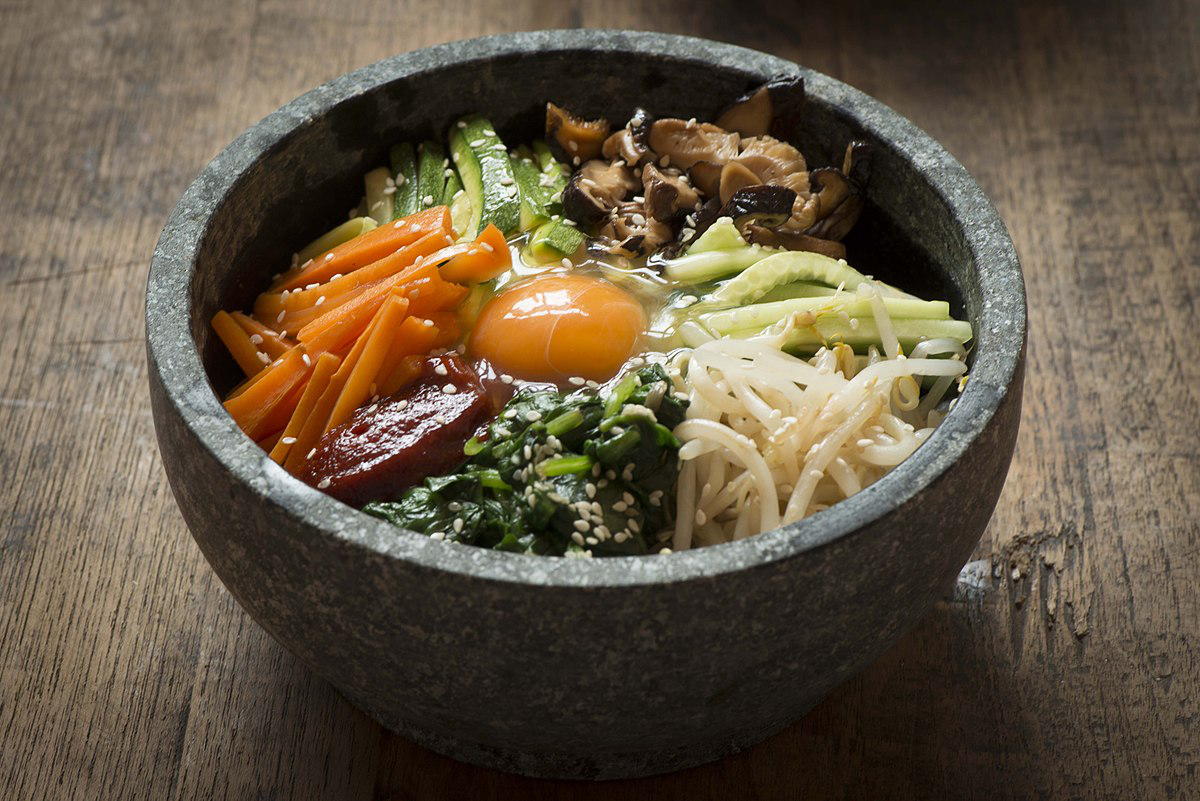

In [45]:
response = requests.get(url)
img = open_image(BytesIO(response.content))
img

In [51]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'bibimbap'

In [47]:
learn.predict(img)

('bibimbap',
 tensor(7),
 tensor([1.2469e-02, 3.1634e+00, 1.6414e-01, 1.4150e-01, 5.4390e-01, 3.2021e+01,
         9.4270e-01, 9.0188e+05, 4.8956e-02, 6.9307e-02]))

In [52]:
res =  zip (learn.data.classes, outputs.tolist())
sorted(res, key=lambda x:x[1], reverse=True)  

[('bibimbap', 901884.0),
 ('beet_salad', 32.02105712890625),
 ('baby_back_ribs', 3.16338849067688),
 ('beignets', 0.9426987767219543),
 ('beef_tartare', 0.5439015626907349),
 ('baklava', 0.16413506865501404),
 ('beef_carpaccio', 0.14149819314479828),
 ('breakfast_burrito', 0.06930666416883469),
 ('bread_pudding', 0.04895569756627083),
 ('apple_pie', 0.01246914453804493)]

# Prepare for production

In [58]:
path.ls()

[PosixPath('../data/subset/train'), PosixPath('../data/subset/models')]

In [60]:
shutil.rmtree("models",ignore_errors=True)

In [64]:
shutil.copytree(path/"models", "../models")

'models'